# Lab 3: ATLAS Data Analysis

In [1]:
import numpy as np #arrays and vector operations
import matplotlib.pyplot as plt #plotting
from scipy.optimize import curve_fit #fitting
import scipy #p-value calculation

# useful constants:
mZ = 91.1880 #GeV/c^2
s_mZ = 0.0020 #GeV/c^2
mW = 80.3692 #GeV/c^2
s_mW = 0.0133 #GeV/c^2
mH = 125.2 #GeV/c^2
s_mH = 0.11 #GeV/c^2
me = 0.51099895 #GeV/c62
s_me = 0.00000000015 #GeV/c^2
mMu = 105.6583755 #MeV/c^2
s_mMu = 0.0000023 #MeV/c^2
mTau = 1776.93 #MeV/c^2
s_mTau = 0.09 #MeV/c^2

## Part 1

In [2]:
data = np.loadtxt("atlas_z_to_ll.csv", delimiter=",", skiprows=1) #load database into numpy array
pt1 = data[:,0]
pt2 = data[:,1]
eta1 = data[:,2]
eta2 = data[:,3]
phi1 = data[:,4]
phi2 = data[:,5]
E1 = data[:,6]
E2 = data[:,7]

p1 = np.array([pt1*np.cos(phi1), pt1*np.sin(phi1), pt1*np.sinh(eta1)]) #calculate the momentum of particle 1 in cartesian coordinates
p2 = np.array([pt2*np.cos(phi2), pt2*np.sin(phi2), pt2*np.sinh(eta2)]) #calculate the momentum of particle 2 in cartesian coordinates
E =  E1+E2 #calculate the energy of the particle that decayed into the two daughter particles
p = p1+p2 #calculate the momentum of the partent particle

M = np.sqrt(E**2-(p[0]**2+p[1]**2+p[2]**2)) #calculate the invarient mass of the parent particle

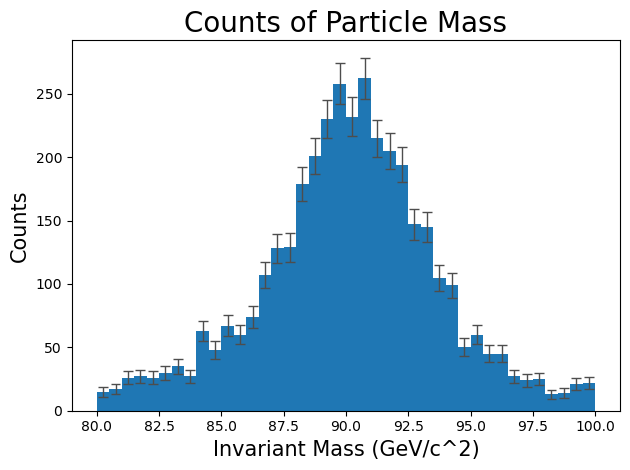

In [3]:
bins = np.linspace(80,100,41) #create the bins for the histogram
binsize=bins[1]-bins[0]

fig, ax = plt.subplots(1,1)
n, b, p = ax.hist(M, bins=bins) #create the bins on the plot
b = b[0:-1] #trim off a bin so that the n and b arrays have the same length
s_n = np.sqrt(n) #calculate the uncertainties in the counts according to Poisson statistics

#Manually plot errorbars with caps
ax.vlines(b+binsize/2, n-s_n, n+s_n, color=(0.3,0.3,0.3), linewidth=1)
ax.hlines(n-s_n, b+binsize*0.1, b+binsize-binsize*0.1, color=(0.3,0.3,0.3), linewidth=1)
ax.hlines(n+s_n, b+binsize*0.1, b+binsize-binsize*0.1, color=(0.3,0.3,0.3), linewidth=1)

#label plot
ax.set_xlabel("Invariant Mass (GeV/c^2)", fontsize=15)
ax.set_ylabel("Counts", fontsize=15)
ax.set_title("Counts of Particle Mass", fontsize=20)
fig.tight_layout()

## Part 2

In [4]:
def D(m, m0, gamma): #model function to fit the data to. The 5000./2. is a normalization factor for the number of parent particles that decay
    return 5000./2.*(gamma)/(2*np.pi*((m-m0)**2+(gamma/2)**2))

mask = (b+binsize/2>87)&(b+binsize/2<93) #create a mask so we only fit to the bins with the highest signal-to-noise ratio
dataX = b[mask]+binsize/2 #shift by binsize/2 so we are fitting to the center of the bins instead of the left edge of the bins
dataY = n[mask]

param, covar = curve_fit(D,dataX, dataY, sigma=s_n[mask], absolute_sigma=True) #fit a model to the data

#evaluate the fit with a finer sampling rate for visualization
evalX = np.linspace(bins[0], bins[-1], 1000) 
fit = D(evalX, param[0], param[1])

m0,gamma=param
s_m0, s_gamma = np.sqrt(np.diag(covar)) #uncertainties in the fit parameters
print(f"m0: ({m0} +- {s_m0}) GeV/c^2\ngamma: ({gamma} +- {s_gamma}) GeV/c^2") #Gamma has units of GeV/c^2 because it is added with mass which has units of GeV/c^2

m0: (90.34080586028303 +- 0.09351482707907852) GeV/c^2
gamma: (6.390998393873239 +- 0.18107387968811411) GeV/c^2


Chi-squared value: 9.985097164263708
degrees of Freedom: 10
Reduced Chi-squared value: 0.9985097164263708
P-value: 0.441801738562729


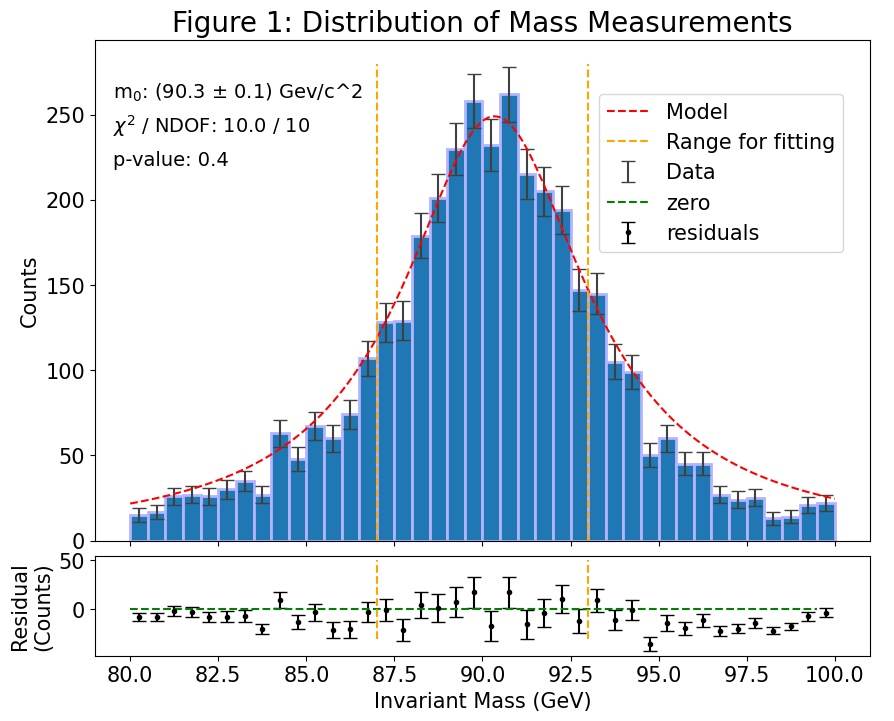

In [5]:
fig, (axd,axr) = plt.subplots(2,1, sharex=True, gridspec_kw={'height_ratios':[5,1], 'hspace':0.05}, figsize=(10,8)) #create plots for both fit and residuals
axd.hist(M, bins=bins, edgecolor=(0.7,0.7,1),linewidth=2)
axd.errorbar(b+binsize/2, n, s_n, fmt=" ", capsize=5, color=(0.25,0.25,0.25), label="Data") #plot errorbars with caps for the histogram
axd.plot(evalX, fit, color="red", linestyle="--", label="Model") #plot the fit function

#calculate the residuals for the data points within the fitting range
model = D(dataX,param[0],param[1])
residuals = dataY-model

chi2 = np.sum((residuals/s_n[mask])**2) #calculate the chi-squared values from the residuals
ndof = len(model)-2 #number of data points fitted - number of fitting parameters
reducedChi2=chi2/(ndof)
pval = scipy.stats.chi2.sf(chi2, ndof)
axd.text(79.5,260,f"m$_0$: ({m0:.1f} $\\pm$ {s_m0:0.1f}) Gev/c^2", fontsize=14)
axd.text(79.5,240,f"$\\chi^2$ / NDOF: {chi2:.1f} / {ndof}", fontsize=14)
axd.text(79.5,220,f"p-value: {pval:.1f}", fontsize=14)
axd.set_title("Figure 1: Distribution of Mass Measurements",fontsize=20)

plotRes = n-D(b+binsize/2, param[0],param[1])
axr.errorbar(b+binsize/2, plotRes,yerr = s_n,capsize=5, fmt=".k", label="residuals")
axr.hlines(0,np.min(b),np.max(b),linestyle="--",color="green",label="zero")
axd.vlines((dataX[0]-binsize/2,dataX[-1]+binsize/2),0,280, linestyle="--",color="orange",label="Range for fitting")
axr.vlines((dataX[0]-binsize/2,dataX[-1]+binsize/2),-30,50, linestyle="--",color="orange")

fig.legend(loc=(0.67,0.65),fontsize=15)
axr.set_xlabel("Invariant Mass (GeV)", fontsize=15)
axr.set_ylabel("Residual\n(Counts)",fontsize=15)
axd.set_ylabel("Counts",fontsize=15);
axr.tick_params(axis="x",labelsize=15)
axd.tick_params(axis="y",labelsize=15)
axr.tick_params(axis="y",labelsize=15)

print(f"Chi-squared value: {chi2}\ndegrees of Freedom: {ndof}\nReduced Chi-squared value: {reducedChi2}\nP-value: {pval}")

## Part 3

<a list of 2 text.Text objects>

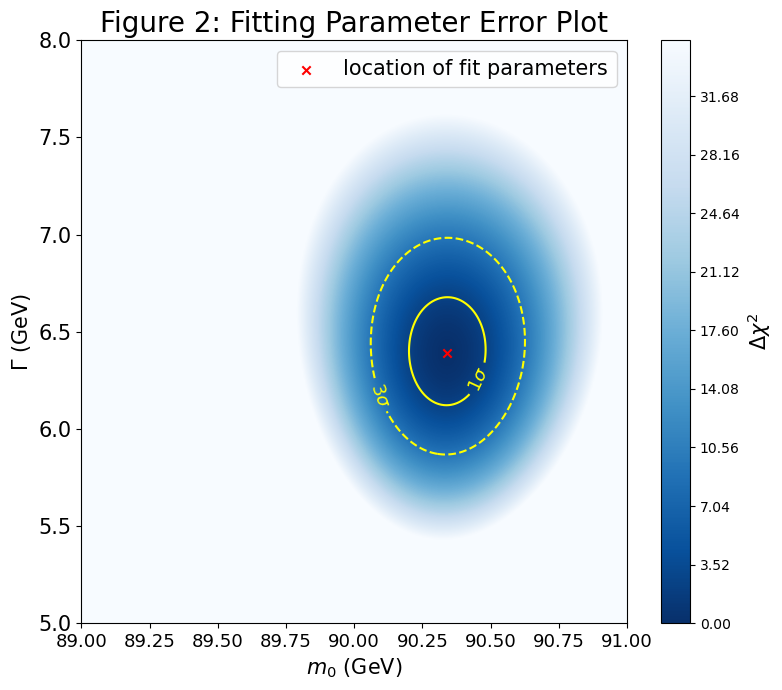

In [6]:
test_m0 = np.linspace(89,91,300) #GeV/c^2
test_gamma = np.linspace(5,8,300) #GeV/c^2

chi2s = np.zeros((len(test_m0),len(test_gamma))) #initialize memory

#calculate chi2 values over a range of possible fitting parameters
for i in range(len(test_m0)):
    for j in range(len(test_gamma)):
        m = test_m0[i]
        g = test_gamma[j]
        model = D(dataX,m,g)
        chi2 = np.sum(((model-dataY)/(s_n[mask]))**2)
        chi2s[j,i]=chi2


deltaChi2s = chi2s-np.min(chi2s) #shift all chi-squared values down by the minimum chi-squared value 
deltaChi2s = np.clip(deltaChi2s,0,35) #clip Delta chi-squred values to 35 so detail can still be seen close to the correct values

X,Y = np.meshgrid(test_m0,test_gamma) #meshgrid for plotting

#plot the gradient portion of the figure
fig, ax = plt.subplots(1,1,figsize=(8,7))
cf= ax.contourf(X,Y,deltaChi2s,levels=500,cmap="Blues_r")
#add colorbar
cbar=fig.colorbar(cf)
cbar.set_label("$\\Delta\\chi^2$",fontsize=15)
#add countours at the 1 and 3 sigma levels and add a marker at the values found by the optimizer
CS = ax.contour(X,Y,deltaChi2s, levels=(2.3,9.21),colors=["yellow"],linestyles=["solid","dashed"])
ax.scatter(m0,gamma,marker="x",color="red",label="location of fit parameters")

#make the figure nicer looking and add labels
ax.set_title("Figure 2: Fitting Parameter Error Plot",fontsize=20)
ax.set_xlabel("$m_0$ (GeV)",fontsize=15)
ax.set_ylabel("$\\Gamma$ (GeV)",fontsize=15)
ax.legend(fontsize=15)
ax.tick_params(axis="x",labelsize=13)
ax.tick_params(axis="y",labelsize=15)
fig.tight_layout()

#add labels to the contour lines
fmt = {}
strs = ["$1\\sigma$", "$3\\sigma$"]
for l, s in zip(CS.levels, strs):
    fmt[l] = s

ax.clabel(CS,CS.levels,fmt=fmt,fontsize=13)